In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

In [2]:
# 주요 디렉토리 경로
user = getpass.getuser()
fit3d_root = '/home/{}/Datasets/HAAI/Fit3D'.format(user)
fit3d_train_root = fit3d_root + '/train'
fit3d_test_root = fit3d_root + '/test'

### generate pkl for each video in Fit3D

In [18]:
train_subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11']
test_subjects = [] # ['s02', 's12', 's13'] -> no gt 3d info
subjects = train_subjects + test_subjects
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
mm_to_m = 1000
# save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl'
# if not os.path.exists(save_folder): os.makedirs(save_folder)
pass_subject = [] # ['s09']
pass_action = [] # ['walk_the_box']
pass_cam = [] # ['65906101']

fig = plt.figure(0, figsize=(3, 3))
fig.clear()
ax = axes_2d(fig, W=900, H=900)

for subject in subjects:
    if subject in test_subjects: data_type = 'test'
    else: data_type = 'train'
    if data_type == 'train': subject_path = os.path.join(fit3d_train_root, subject)
    else: subject_path = os.path.join(fit3d_test_root, subject)
    if len(pass_subject) > 0 and subject not in pass_subject: continue
    
    for cam_num in os.listdir(os.path.join(subject_path, 'videos')):
        cam_path = os.path.join(subject_path, 'videos', cam_num)
        if len(pass_cam) > 0 and cam_num not in pass_cam: continue
        pbar = tqdm(action_list)
        for action in pbar:
            if len(pass_action) > 0 and action not in pass_action: continue
            file_name = '{}_{}_{}.pkl'.format(subject, cam_num, action)
            gt_3d, camera_param = fit3d_load_gt_and_param(fit3d_root, cam_num, data_type, subject, action)
            fx = camera_param['intrinsic'][0, 0]  
            fy = camera_param['intrinsic'][1, 1]  
            cx = camera_param['intrinsic'][0, 2]  
            cy = camera_param['intrinsic'][1, 2] 
            
            num_frames = len(gt_3d)
            frame_num = random.randint(0, num_frames-1)
            
            video_path = os.path.join(subject_path, 'videos', cam_num, action+'.mp4')
            img = get_video_frame(video_path, frame_id=frame_num)
            
            
            #for frame_num in tqdm(range(num_frames)):
            # check whether gt is available
            try: test = np.array(gt_3d[frame_num])[:17, :]
            except: continue

            # joint3d_image
            world_3d = np.array(gt_3d[frame_num])[:17, :] # (17, 3)
            
            # world to camera
            pos = copy.deepcopy(world_3d)
            cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
            cam_3d_hat = get_rootrel_pose(cam_3d)

            # camera to image
            box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
            img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
            
            clear_axes(ax)
            draw_2d_pose(ax, img_2d, color='r', W=900, H=900, img=img)
            plt.savefig('/home/hrai/codes/MotionBERT/custom_codes/Dataset_generation/fit3d/check_fit3d_camera_parameters/{}_{}_{}_{}.png'.format(subject, cam_num, action, frame_num), dpi=40, bbox_inches='tight', transparent=False)
            
            pbar.set_postfix({'subject': subject, 'cam_num': cam_num, 'action': action, 'frame_num': frame_num})
    #         break
    #     break
    # break

100%|██████████| 47/47 [00:12<00:00,  3.76it/s, subject=s11, cam_num=60457274, action=dumbbell_reverse_lunge, frame_num=243]          


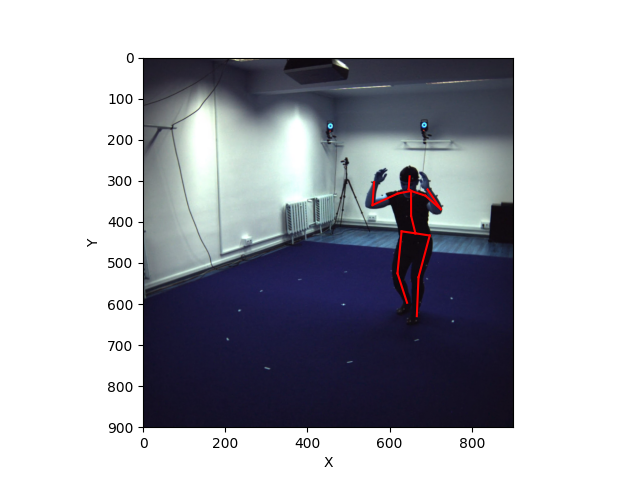

In [7]:
frame_num = 700

fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig, W=900, H=900)
draw_2d_pose(ax, img_2ds[frame_num], color='r', W=900, H=900, img=frames[frame_num])
plt.show()

### fit3d_gt_all_train_except_target_action.pkl 생성

In [90]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11']
train_subjects = subjects
test_subjects = subjects
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
test_action = ['pushup', 'burpees', 'squat']
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl'

for item in tqdm(os.listdir(pkl_folder)):
    #print(item)
    subject, cam_num, action = item[:3], item[4:12], item[13:-4]
    #print(subject, cam_num, action)
    item_path = os.path.join(pkl_folder, item)
    data = readpkl(item_path)
    #print(data.keys())
    if action in test_action: data_type = 'test'
    else: data_type = 'train'
    joint_2ds[data_type] += data['joint_2d']
    confidences[data_type] += data['confidence']
    joint3d_images[data_type] += data['joint3d_image']
    joints_25d_images[data_type] += data['joints_2.5d_image']
    _25d_factors[data_type] += data['2.5d_factor']
    camera_names[data_type] += data['camera_name']
    actions[data_type] += data['action']
    sources[data_type] += data['source']
    frames[data_type] += data['frame']
    world_3ds[data_type] += data['world_3d']
    cam_3ds[data_type] += data['cam_3d']
    cam_params[data_type] += data['cam_param']

100%|██████████| 1504/1504 [00:21<00:00, 69.02it/s]


In [44]:
fit3d_gt_all_train_except_target_action = {'train': {}, 'test': {}}

same_as_train = False
for data_type in ['train', 'test']:
    data_type_ = data_type
    if same_as_train:
        data_type_ = 'train'
    fit3d_gt_all_train_except_target_action[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    fit3d_gt_all_train_except_target_action[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))

In [49]:
print(len(fit3d_gt_all_train_except_target_action['train']['joint_2d']), len(fit3d_gt_all_train_except_target_action['test']['joint_2d']))

1666432 112860


In [50]:
save_path = os.path.join(motionbert_root, 'data/motion3d/fit3d_gt_all_train_except_target_action.pkl')
savepkl(fit3d_gt_all_train_except_target_action, save_path)

### fit3d_target_action.pkl

In [9]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11']
train_subjects = subjects
test_subjects = subjects
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
test_action = ['pushup', 'burpees', 'squat']
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl'

for item in tqdm(os.listdir(pkl_folder)):
    #print(item)
    subject, cam_num, action = item[:3], item[4:12], item[13:-4]
    #print(subject, cam_num, action)
    item_path = os.path.join(pkl_folder, item)
    data = readpkl(item_path)
    #print(data.keys())
    if action in test_action: data_type = 'train'
    else: continue
    joint_2ds[data_type] += data['joint_2d']
    confidences[data_type] += data['confidence']
    joint3d_images[data_type] += data['joint3d_image']
    joints_25d_images[data_type] += data['joints_2.5d_image']
    _25d_factors[data_type] += data['2.5d_factor']
    camera_names[data_type] += data['camera_name']
    actions[data_type] += data['action']
    sources[data_type] += data['source']
    frames[data_type] += data['frame']
    world_3ds[data_type] += data['world_3d']
    cam_3ds[data_type] += data['cam_3d']
    cam_params[data_type] += data['cam_param']

100%|██████████| 1504/1504 [00:21<00:00, 69.39it/s]


In [10]:
fit3d_test_target_action = {'train': {}, 'test': {}}

same_as_train = True
for data_type in ['train', 'test']:
    data_type_ = data_type
    if same_as_train:
        data_type_ = 'train'
    fit3d_test_target_action[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    fit3d_test_target_action[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    fit3d_test_target_action[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    fit3d_test_target_action[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    fit3d_test_target_action[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    fit3d_test_target_action[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    fit3d_test_target_action[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    fit3d_test_target_action[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    fit3d_test_target_action[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    fit3d_test_target_action[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    fit3d_test_target_action[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    fit3d_test_target_action[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))

In [11]:
print(len(fit3d_test_target_action['train']['joint_2d']), len(fit3d_test_target_action['test']['joint_2d']))

112860 112860


In [12]:
save_path = os.path.join(motionbert_root, 'data/motion3d/fit3d_test_target_action.pkl')
savepkl(fit3d_test_target_action, save_path)

### Alphapose test pkl

In [13]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11'] # ['s02', 's12', 's13']
train_subjects = subjects
test_subjects = subjects
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
test_action = ['pushup', 'burpees', 'squat']
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl'
ap_result_folder = '/home/hrai/codes/AlphaPose/examples/fit3d_result_3actions'

for item in tqdm(os.listdir(pkl_folder)):
    subject, cam_num, action = item[:3], item[4:12], item[13:-4]
    if action not in test_action: continue
    if subject in train_subjects: data_type = 'train'
    else: data_type = 'test'
    #print(subject, cam_num, action)
    item_path = os.path.join(pkl_folder, item)
    data = readpkl(item_path)
    gt_3d, camera_param = fit3d_load_gt_and_param(fit3d_root, data_type, subject, action, cam_num)
    file_name = 'res_{}_{}_{}_{}'.format(data_type, subject, cam_num, action)
    #print(file_name)
    ap_result = readJSON(os.path.join(ap_result_folder, file_name, 'alphapose-results.json'))
    #print(ap_result[0])
    #print('ap num: ', len(ap_result), 'gt num: ', len(data['joint_2d']))

    # alphapose 결과 추출
    id_list = []
    new_joint_2ds = []
    new_confidences = []
    for frame in ap_result:
        image_id = int(frame['image_id'].split('.')[0])
        if image_id in id_list: continue # 중복 image_id 제거
        if image_id >= len(data['joint_2d']): continue # image_id가 gt의 길이보다 길면 제거
        #print(image_id)
        id_list.append(image_id)
        keypoints = halpe2h36m(np.array(frame['keypoints']).reshape(1, -1, 3))[0]
        new_joint_2ds.append(keypoints[:, :2])
        new_confidences.append(keypoints[:, 2])
    #print(len(id_list), len(new_joint_2ds), len(new_confidences))
    #print(id_list)
    #print(len(data['joint3d_image']))

    joint_2ds[data_type]         += new_joint_2ds
    confidences[data_type]       += new_confidences
    joint3d_images[data_type]    += list(np.array(data['joint3d_image'])[id_list])
    joints_25d_images[data_type] += list(np.array(data['joints_2.5d_image'])[id_list])
    _25d_factors[data_type]      += list(np.array(data['2.5d_factor'])[id_list])
    camera_names[data_type]      += list(np.array(data['camera_name'])[id_list])
    actions[data_type]           += list(np.array(data['action'])[id_list])
    sources[data_type]           += list(np.array(data['source'])[id_list])
    frames[data_type]            += list(np.array(data['frame'])[id_list])
    world_3ds[data_type]         += list(np.array(data['world_3d'])[id_list])
    cam_3ds[data_type]           += list(np.array(data['cam_3d'])[id_list])
    cam_params[data_type]        += list(np.array(data['cam_param'])[id_list])
    #break

100%|██████████| 1504/1504 [00:10<00:00, 146.26it/s]


In [18]:
fit3d_target_action_test_with_ap = {'train': {}, 'test': {}}

same_as_train = True
for data_type in ['train', 'test']:
    data_type_ = data_type
    if same_as_train:
        data_type_ = 'train'
    fit3d_target_action_test_with_ap[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))

In [19]:
for key in fit3d_target_action_test_with_ap[data_type].keys():
    print(key, len(fit3d_target_action_test_with_ap['train'][key]), len(fit3d_target_action_test_with_ap['test'][key]))

joint_2d 109753 109753
confidence 109753 109753
joint3d_image 109753 109753
joints_2.5d_image 109753 109753
2.5d_factor 109753 109753
camera_name 109753 109753
action 109753 109753
source 109753 109753
frame 109753 109753
world_3d 109753 109753
cam_3d 109753 109753
cam_param 109753 109753


In [20]:
fit3d_target_action_test_with_ap['test']['joint_2d'].shape

(109753, 17, 2)

In [ ]:
fit3d_target_action_test_with_ap

In [17]:
save_path = os.path.join(motionbert_root, 'data/motion3d/fit3d_test_target_action_with_ap.pkl')
savepkl(fit3d_target_action_test_with_ap, save_path)

In [24]:
readpkl(save_path)['train']['joint_2d'].shape

(109753, 17, 2)

### Compare fit3d_test_target_action_with_ap and fit3d_gt_all_train_except_target_action

In [5]:
fit3d_gt_all_train_except_target_action = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_all_train_except_target_action.pkl')
fit3d_test_target_action_with_ap = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/fit3d_test_target_action_with_ap.pkl')

In [7]:
fit3d_all_train_except_target_action['train']['joint_2d'].shape, fit3d_all_train_except_target_action['test']['joint_2d'].shape

((1666432, 17, 2), (112860, 17, 2))

In [8]:
fit3d_test_target_action_with_ap['train']['joint_2d'].shape, fit3d_test_target_action_with_ap['test']['joint_2d'].shape

((109753, 17, 2), (109753, 17, 2))

### Visualization

In [8]:
fit3d_root

'/home/hrai/Datasets/HAAI/Fit3D'

In [65]:
frame_num = 0

gt_3d, camera_param_50591643 = fit3d_load_gt_and_param(fit3d_root, 'train', 's03', 'pushup', '50591643')
world_3d = np.array(gt_3d[frame_num])[:17, :]

Cs = []
ts = []
img_2ds = []
cameras = []
cam_list = ['50591643', '58860488', '60457274', '65906101']

for cam in cam_list:
    gt_3d, camera_param = fit3d_load_gt_and_param(fit3d_root, 'train', 's03', 'pushup', cam)
    extrinsic_matrix = camera_param['extrinsic']
    intrinsic_matrix = camera_param['intrinsic']
    t = extrinsic_matrix[:3, 3]
    R = extrinsic_matrix[:3, :3]
    C = - R.T @ t
    keypoints_3d_cam = World2CameraCoordinate(world_3d.copy(), extrinsic_matrix)
    keypoints_proj = (intrinsic_matrix @ keypoints_3d_cam.copy().T).T
    keypoints_proj /= np.repeat(keypoints_proj[:, 2].reshape(-1, 1), 3, axis=1)
    cam_origin = C

    forward = [1, 0, 0]
    left = [0, -1, 0]
    up = np.cross(forward, left)
    cam_default_R = np.array([left, up, forward]) # default camera orientation

    camera = Camera(origin=cam_origin, 
                    calib_mat=intrinsic_matrix, 
                    cam_default_R=R, 
                    roll=0,
                    pitch=0,
                    yaw=0,
                    IMAGE_HEIGHT=1000, 
                    IMAGE_WIDTH=1000,
                    cam_name=cam)
    
    Cs.append(C)
    ts.append(t)
    img_2ds.append(keypoints_proj)
    cameras.append(camera)

[111.85419034   2.34327685 101.30407527]
[ 61.65461688   0.56760598 100.15727475]
[-65.00656443  -0.55550461  99.59659077]
[-115.43979507    0.13552381  101.22197109]


In [63]:
Rotation.from_matrix(R).as_euler('xyz', degrees=True)

array([-114.81247659,   62.37104857,  157.86369508])

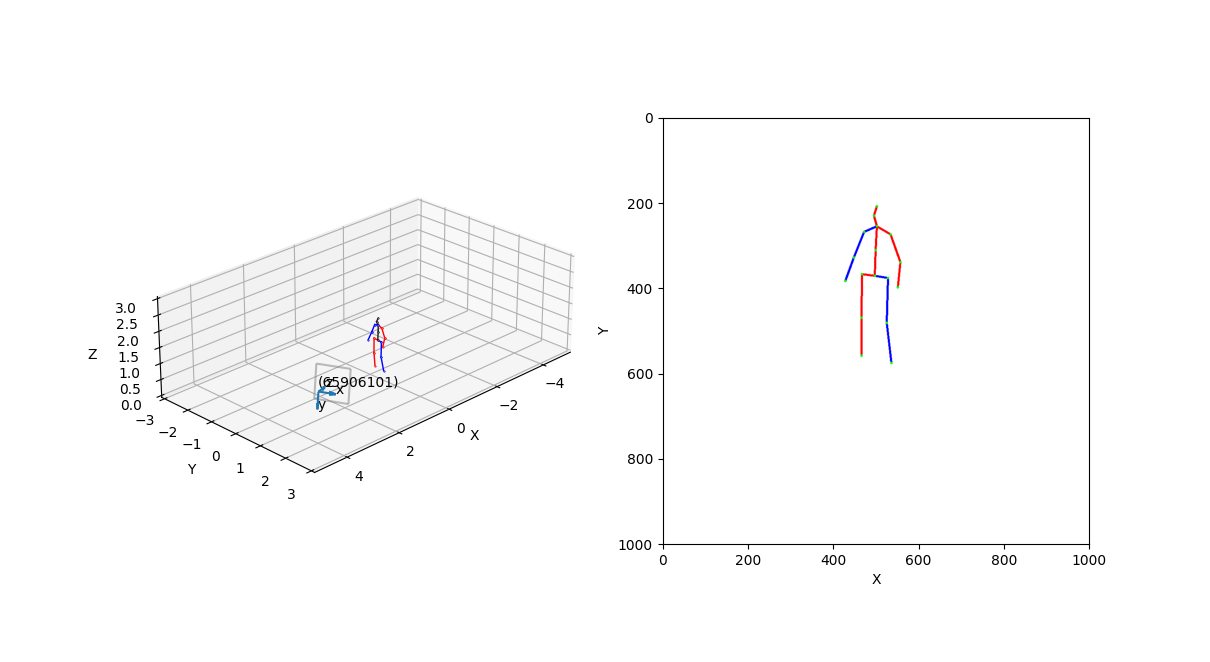

In [52]:
%matplotlib widget
# draw 3d pose and camera frame
fig = plt.figure(1)
fig.clear()

ax1 = axes_3d(fig=fig, loc=121, xlim=(-5, 5), ylim=(-3, 3), zlim=(0, 3), view=[25, 45])
plt.sca(ax1)
draw_3d_pose(ax1, world_3d, dataset='fit3d')
camera.cam_frame.draw3d()
#camera.image_frame.draw3d()
camera.image_plane.draw3d()

ax2 = axes_2d(fig=fig, loc=122)
plt.sca(ax2)
img = get_2d_pose_image(keypoints_proj, dataset='h36m')
ax2.imshow(img)

plt.show()

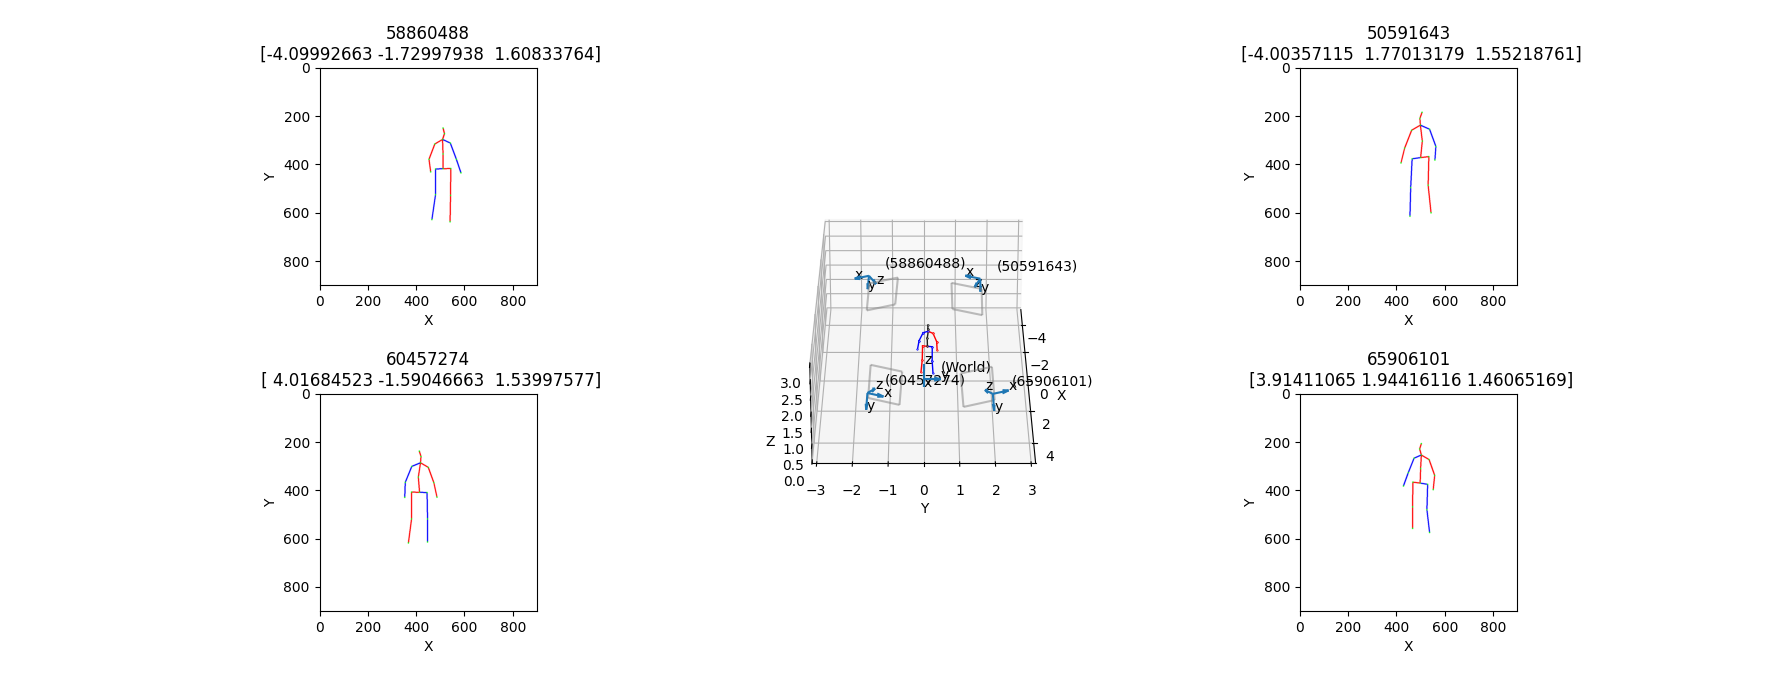

In [61]:
%matplotlib widget
# draw 3d pose and camera frame
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig = plt.figure(2)
fig.clear()

world_frame = generate_world_frame()

ax_3d = axes_3d(fig=fig, loc=132, xlim=(-5, 5), ylim=(-3, 3), zlim=(0, 3), view=[25, 0])
ax_cam1 = axes_2d(fig=fig, loc=231, H=900, W=900)
ax_cam2 = axes_2d(fig=fig, loc=233, H=900, W=900)
ax_cam3 = axes_2d(fig=fig, loc=234, H=900, W=900)
ax_cam4 = axes_2d(fig=fig, loc=236, H=900, W=900)

plt.sca(ax_3d)
draw_3d_pose(ax_3d, world_3d, dataset='fit3d')
world_frame.draw3d()
for i in range(4):
    cameras[i].cam_frame.draw3d()
    #cameras[i].image_frame.draw3d()
    cameras[i].image_plane.draw3d()


plt.sca(ax_cam1)
img = get_2d_pose_image(img_2ds[1], dataset='h36m')
ax_cam1.imshow(img)
ax_cam1.set_title('{}\n {}'.format(cam_list[1], Cs[1]))

plt.sca(ax_cam2)
img = get_2d_pose_image(img_2ds[0], dataset='h36m')
ax_cam2.imshow(img)
ax_cam2.set_title('{}\n {}'.format(cam_list[0], Cs[0]))

plt.sca(ax_cam3)
img = get_2d_pose_image(img_2ds[2], dataset='h36m')
ax_cam3.imshow(img)
ax_cam3.set_title('{}\n {}'.format(cam_list[2], Cs[2]))

plt.sca(ax_cam4)
img = get_2d_pose_image(img_2ds[3], dataset='h36m')
ax_cam4.imshow(img)
ax_cam4.set_title('{}\n {}'.format(cam_list[3], Cs[3]))

plt.show()